<a href="https://colab.research.google.com/github/sanchezis/08MBID-Visualizacion-de-Datos/blob/main/08MBID_TP_GoogleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/sanchezis/08MBID-Visualizacion-de-Datos/blob/main/08MBID_TP_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08MIBD - Trabajo Práctico
Máster en Big Data y Ciencia de Datos

Alumno: Israel Sánchez Llorens.<br/>

[StackBlitz Website](https://israelllorens.stackblitz.io)<br/>
[Google Colab](https://colab.research.google.com/drive/1Iv-USAX6bXpMT-YAAuunIUCO7lYtPRoe?usp=sharing)<br/>
[Github Repository](https://github.com/sanchezis/08MBID-Visualizacion-de-Datos)<br/>


In [1]:
!pip install plotly
!pip install plotly-geo
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


## Carga de datos

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objects import Layout
import requests

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None
import io
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import json
import requests
import geopandas as gpd
from datetime import datetime

pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 1000)

IN_COLAB=False
try:
  from google.colab import files
  IN_COLAB=True
except:
  pass

def read_url_csv(url):
  from io import StringIO
  response = requests.get(url, verify=False)
  return pd.read_csv(StringIO(response.text))


# Function to convert yyyyww format to datetime
def convert_to_datetime(date_as_integer):
    date_str = str(date_as_integer)
    year = int(date_str[:4])
    week = int(date_str[4:])
    return datetime.strptime(f'{year}-{week}-1', '%G-%V-%u')


In [3]:
clinical_health = read_url_csv("https://raw.githubusercontent.com/sanchezis/08MBID-Visualizacion-de-Datos/main/data/clinical-sentinel-laboratory-influenza-and-other-respiratory-virus-surveillance-data-by-region-and-influenza-season.csv")
public_health = read_url_csv("https://raw.githubusercontent.com/sanchezis/08MBID-Visualizacion-de-Datos/main/data/public-health-laboratory-influenza-respiratory-virus-surveillance-data-by-region-and-influenza-season.csv")
insurance = read_url_csv("https://raw.githubusercontent.com/sanchezis/08MBID-Visualizacion-de-Datos/main/data/insurance.csv")

public_health = public_health.rename(columns={'Influenza_Category': 'Respiratory_Virus',
                             'Count': 'Number_Positive'})
clinical_health = clinical_health.drop('Percent_Positive', axis=1).drop('Specimens_Tested', axis=1)

# Apply the function to the DataFrame column
clinical_health['date_code'] = clinical_health['date_code'].apply(convert_to_datetime)
public_health['date_code'] = public_health['date_code'].apply(convert_to_datetime)

# Apply the function to the DataFrame column
clinical_health['weekending'] = pd.to_datetime(clinical_health['weekending'])
public_health['weekending'] = pd.to_datetime(public_health['weekending'])

clinical_health = clinical_health[~clinical_health.Respiratory_Virus.str.lower().str.contains('total')]
public_health = public_health[~public_health.Respiratory_Virus.str.lower().str.contains('total')]

clinical_health = clinical_health[~clinical_health.Respiratory_Virus.str.lower().str.contains('tested')]
public_health = public_health[~public_health.Respiratory_Virus.str.lower().str.contains('tested')]

public_health = public_health[~ (public_health.Respiratory_Virus == 'Influenza_A') ]

clinical_health = clinical_health[~clinical_health.region.str.lower().str.contains('california')]
public_health = public_health[~public_health.region.str.lower().str.contains('california')]

clinical_health = clinical_health[~clinical_health.region.str.lower().str.contains('california')]
public_health = public_health[~public_health.region.str.lower().str.contains('california')]

clinical_health.loc[clinical_health.region.str.lower().str.contains('northern'), 'region'] = 'Northern'
public_health.loc[public_health.region.str.lower().str.contains('northern'), 'region'] = 'Northern'

clinical_health.loc[clinical_health.region.str.lower().str.contains('southern'), 'region'] = 'Southern'
public_health.loc[public_health.region.str.lower().str.contains('southern'), 'region'] = 'Southern'

clinical_health['year'] = clinical_health.date_code.dt.year
clinical_health['month'] = clinical_health.date_code.dt.month
public_health['year'] = public_health.date_code.dt.year
public_health['month'] = public_health.date_code.dt.month
clinical_health = clinical_health[clinical_health.year>2009]
public_health = public_health[public_health.year>2009]


clinical_health = clinical_health.groupby(['season',	'date_code',	'weekending',	'region', 'Respiratory_Virus', 'year', 'month' ]).agg({'Number_Positive':'sum'}).reset_index()
public_health   = public_health  .groupby(['season',	'date_code',	'weekending',	'region', 'Respiratory_Virus', 'year', 'month' ]).agg({'Number_Positive':'sum'}).reset_index()

insurance = insurance.rename(columns={
    'age':'Edad',
    'sex':'Sexo',
    'children':'Hijos',
    'region': 'Region',
    'charges': 'Precio',
    'smoker':'Fumador'
})


insurance.loc[insurance['Fumador']=='yes', 'Fumador'] = 'Si'
insurance.loc[insurance['Fumador']=='no', 'Fumador'] = 'No'

insurance.loc[insurance['Sexo']=='female', 'Sexo'] = 'Mujer'
insurance.loc[insurance['Sexo']=='male', 'Sexo'] = 'Hombre'

insurance.to_csv('./sample_data/insurance.csv')
clinical_health.to_csv("./sample_data/clinical_health.csv")
public_health.to_csv("./sample_data/public_health.csv")



clinical_health.index = clinical_health.date_code.dt.to_period('m')
clinical_health_groupby_date_region_virus = clinical_health.drop('date_code', axis=1).groupby(['date_code', 'region','Respiratory_Virus']).agg({'Number_Positive': 'sum'}).reset_index()
clinical_health_groupby_date_region_virus.to_csv('./sample_data/clinical_health_groupby_date_region_virus.csv')



## EDA

In [4]:
# Set layout with background color you want (rgba values)
# This one is for white background
layout = Layout(plot_bgcolor='rgba(0,0,0,0)',
                paper_bgcolor='rgba(0,0,0,0)',
                )

# Use that layout here
fig = go.Figure(layout=layout)

fig = px.box(insurance, x='Sexo', y='Precio', points="all", color="Fumador",
             color_discrete_map = {'Si': 'maroon', 'No': 'green'},
             notched=True, # title=""

             )
fig.update_layout(
    font=dict(
        family="Arial, monospace",
        size=18,  # Set the font size here
        color="Grey"
    ),
    autosize=False,
    width=1200,
    height=500,
)
fig.update_layout(
    {
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
    }
)
fig.update_xaxes(showline=True, linewidth=1, linecolor='grey', ) # gridcolor='Red'
fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', gridcolor='lightgrey')
fig.update_layout(title='<b>Comparativa de Precios entre Mujeres y Hombres</b> <i>según estado Fumador</i>')
fig.update_yaxes(tickfont_family="Arial") # Black
fig.update_layout(
    title={
        # 'text': name,
        #'y':0.9,
        #'x':0.5,
        #'xanchor': 'center',
        'yanchor': 'top',
        },
        font=dict(family="Arial, black",size=14, color= 'black'),
        #barmode='stack',
        #legend=dict(x=0.4, y=-0.3),
        #legend_orientation="h"
        )
fig.update_yaxes(ticklabelposition="outside top", title=None)
fig.update_layout(
    xaxis={'side': 'bottom'},
    yaxis={'side': 'left'}
)
fig.add_annotation(
    xref="x domain",
    yref="y domain",
    x=0.005,
    y=0.98,
    text="Precio",
    showarrow=False
)

fig.write_html('./sample_data/fig1_boxplot.html')
fig.write_image("./sample_data/fig1_boxplot.png", scale=2)
fig.show()

In [5]:
clinical_health #.pivot(index="Respiratory_Virus", columns="date_code", values="Number_Positive")
clinical_health_groupby_date_region_virus

,date_code,region,Respiratory_Virus,Number_Positive
0,2010-01,Bay Area,Influenza_A,66
1,2010-01,Bay Area,Influenza_B,0
2,2010-01,Bay Area,RSV,643
3,2010-01,Central,Influenza_A,24
4,2010-01,Central,Influenza_B,1
...,...,...,...,...
5483,2020-09,Southern,Parainfluenza_2,0
5484,2020-09,Southern,Parainfluenza_3,0
5485,2020-09,Southern,Parainfluenza_4,1
5486,2020-09,Southern,Parainfluenza_UnknownType,0


In [6]:
clinical_health_groupby_date_region_virus

,date_code,region,Respiratory_Virus,Number_Positive
0,2010-01,Bay Area,Influenza_A,66
1,2010-01,Bay Area,Influenza_B,0
2,2010-01,Bay Area,RSV,643
3,2010-01,Central,Influenza_A,24
4,2010-01,Central,Influenza_B,1
...,...,...,...,...
5483,2020-09,Southern,Parainfluenza_2,0
5484,2020-09,Southern,Parainfluenza_3,0
5485,2020-09,Southern,Parainfluenza_4,1
5486,2020-09,Southern,Parainfluenza_UnknownType,0


<Axes: xlabel='date_code', ylabel='Number_Positive'>

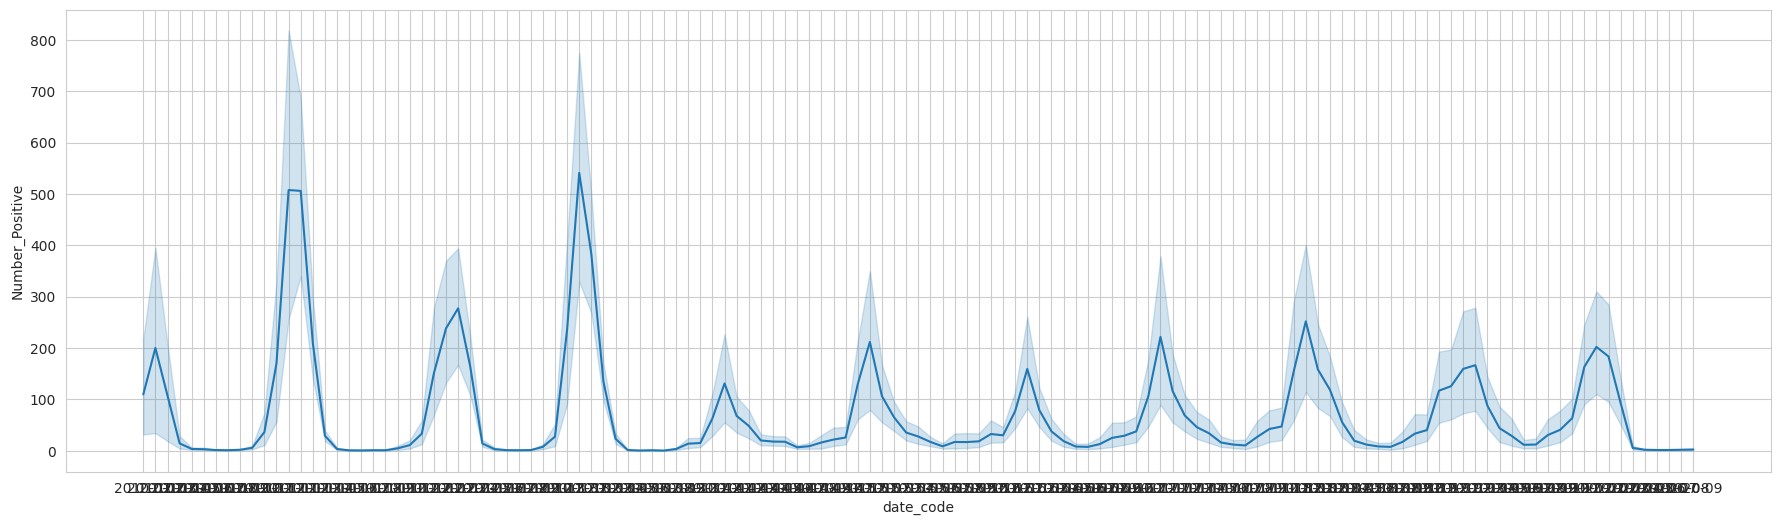

In [7]:
fig, ax = plt.subplots(figsize=(22,6))
sns.lineplot(x=clinical_health_groupby_date_region_virus['date_code'].astype(str), y='Number_Positive',
             data=clinical_health_groupby_date_region_virus,) # 'Respiratory_Virus'



Values:

Bay Area: Includes Alameda, Contra Costa, Marin, Napa, San Francisco, San Mateo, Santa Clara, Santa Cruz, Solano, and Sonoma counties

Central: Includes Calaveras, Fresno, Inyo, Kings, Madera, Mariposa, Merced, Mono, Monterey, San Benito, San Joaquin, Stanislaus, Tulare, and Tuolumne counties

Northern: Includes Alpine, Amador, Butte, Colusa, Del Norte, El Dorado, Glenn, Humboldt, Lake, Lassen, Mendocino, Modoc, Nevada, Placer, Plumas, Sacramento, Shasta, Sierra, Siskiyou, Sutter, Tehama, Trinity, Yolo, and Yuba counties

Upper Southern: Includes Kern, Los Angeles, San Luis Obispo, Santa Barbara, and Ventura counties Lower Southern: Includes Imperial, Orange, Riverside, San Bernardino, and San Diego counties

Upper/Lower Southern: Includes data from a regional laboratory covering counties included in the Upper Southern and Lower Southern regions that could not be assigned to a more specific region.

Note: Not all counties in region have clinical sentinel laboratories.


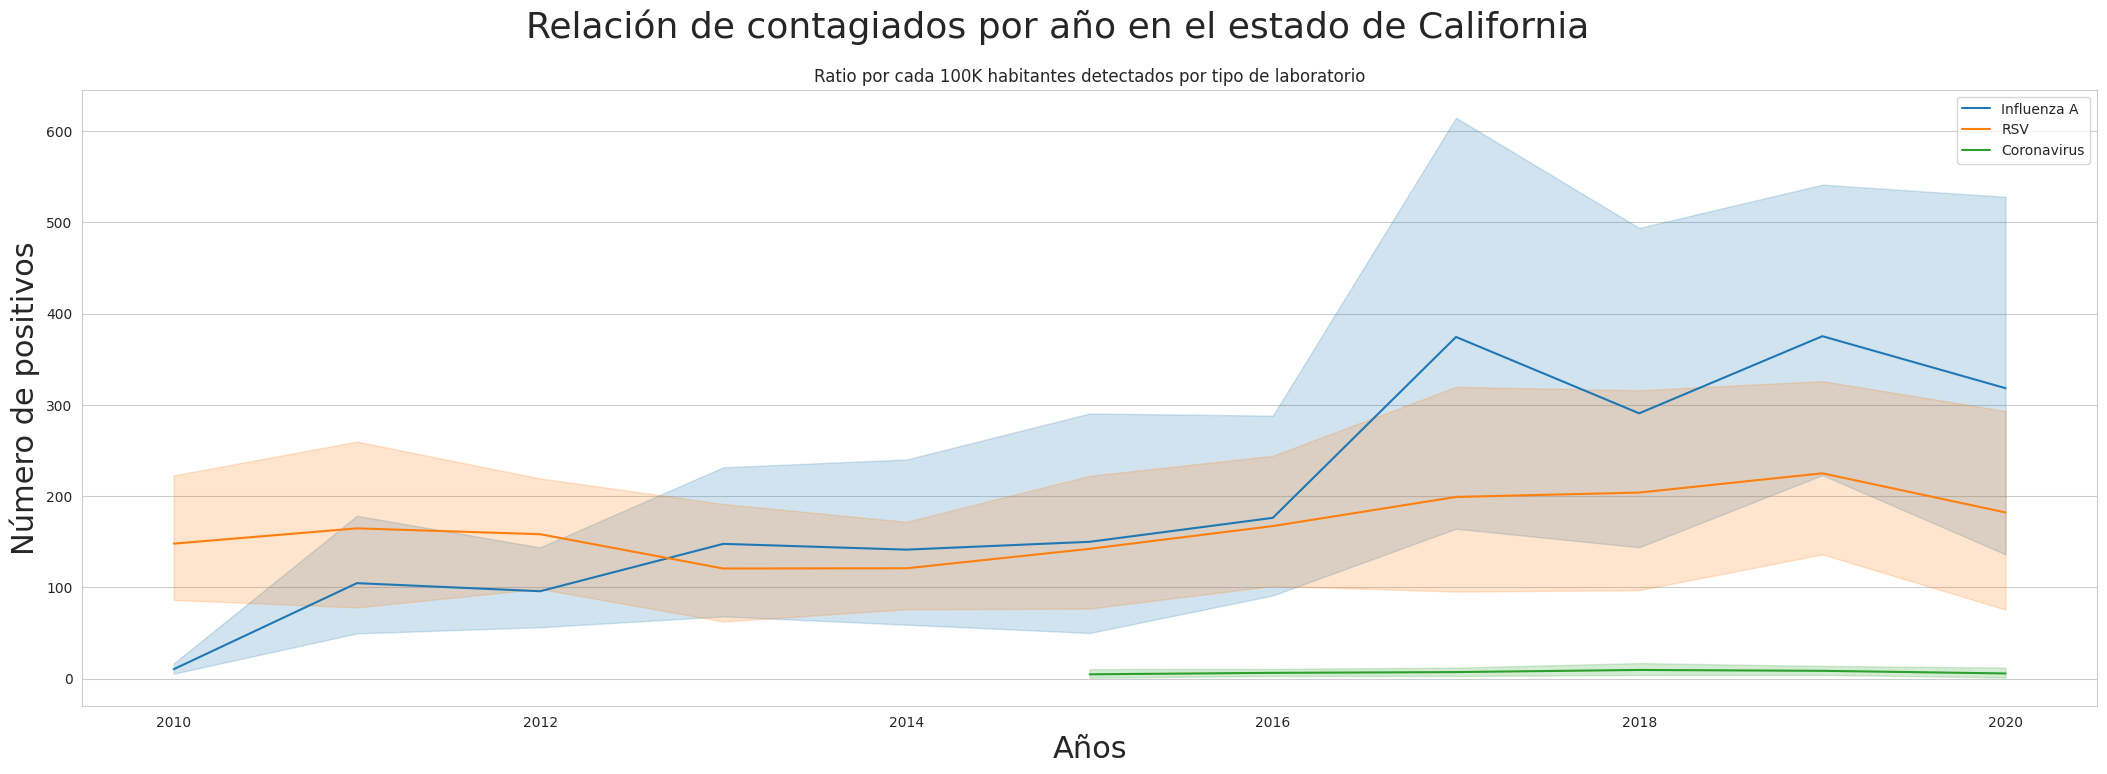

In [8]:
fig, ax = plt.subplots(figsize=(26, 8))
sns.lineplot(x='year', y='Number_Positive', data= clinical_health[clinical_health.Respiratory_Virus=='Influenza_A'].groupby(['year', 'month', 'region', 'Respiratory_Virus']).agg({'Number_Positive': 'sum'}) , label="Influenza A")
sns.lineplot(x='year', y='Number_Positive', data= clinical_health[clinical_health.Respiratory_Virus=='RSV'].groupby(['year', 'month', 'region', 'Respiratory_Virus']).agg({'Number_Positive': 'sum'}) , label="RSV")
sns.lineplot(x='year', y='Number_Positive', data= clinical_health[clinical_health.Respiratory_Virus.str.lower().str.contains('corona')].groupby(['year', 'month', 'region', 'Respiratory_Virus']).agg({'Number_Positive': 'sum'}) ,
                        label="Coronavirus")

plt.suptitle("Relación de contagiados por año en el estado de California", size=26)
ax.set_title("Ratio por cada 100K habitantes detectados por tipo de laboratorio")
ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(False) # Show the vertical gridlines
ax.set_ylabel("Número de positivos", size=22)
ax.set_xlabel("Años", size=22)
plt.savefig('./sample_data/virus_by_year.png', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
df = clinical_health_groupby_date_region_virus.groupby(["Respiratory_Virus", 'region']).agg({'Number_Positive':'sum'}) \
    .reset_index().pivot(index="Respiratory_Virus", columns= "region", values="Number_Positive")
display(df.head(10))
df.to_csv('./sample_data/pivot.csv')

region,Bay Area,Central,Northern,Southern
Respiratory_Virus,,,,
Adenovirus,2034,1305,496,5892
Coronavirus_229E,0,97,0,44
Coronavirus_HKU1,52,188,0,481
Coronavirus_NL63,24,198,0,72
Coronavirus_OC43,22,293,0,181
Coronavirus_UnknownType,0,548,0,6760
Enterovirus_Rhinovirus,10108,8889,1759,44141
HMPV,2095,1445,337,8912
Influenza_A,38136,14398,10115,38383


In [10]:
df = clinical_health_groupby_date_region_virus.groupby(["Respiratory_Virus", 'region', 'date_code']).agg({'Number_Positive':'sum'}) \
    .reset_index().pivot(index="Respiratory_Virus", columns= ['date_code', "region"], values="Number_Positive").fillna(0).T.sort_index()
display(df.head(10))
df.to_csv('./sample_data/pivot_by_date.csv')

Respiratory_Virus   Adenovirus  Coronavirus_229E  Coronavirus_HKU1  \
date_code region                                                     
2010-01   Bay Area         0.0               0.0               0.0   
          Central          0.0               0.0               0.0   
          Northern         0.0               0.0               0.0   
          Southern         0.0               0.0               0.0   
2010-02   Bay Area         0.0               0.0               0.0   
          Central          0.0               0.0               0.0   
          Northern         0.0               0.0               0.0   
          Southern         0.0               0.0               0.0   
2010-03   Bay Area         0.0               0.0               0.0   
          Central          0.0               0.0               0.0   

Respiratory_Virus   Coronavirus_NL63  Coronavirus_OC43  \
date_code region                                         
2010-01   Bay Area               0.0               0.0   
          Central                0.0               0.0   
          Northern               0.0               0.0   
          Southern               0.0               0.0   
2010-02   Bay Area               0.0               0.0   
          Central                0.0               0.0   
          Northern               0.0               0.0   
          Southern               0.0               0.0   
2010-03   Bay Area               0.0               0.0   
          Central                0.0               0.0   

Respiratory_Virus   Coronavirus_UnknownType  Enterovirus_Rhinovirus  HMPV  \
date_code region                                                            
2010-01   Bay Area                      0.0                     0.0   0.0   
          Central                       0.0                     0.0   0.0   
          Northern                      0.0                     0.0   0.0   
          Southern                      0.0                     0.0   0.0   
2010-02   Bay Area                      0.0                     0.0   0.0   
          Central                       0.0                     0.0   0.0   
          Northern                      0.0                     0.0   0.0   
          Southern                      0.0                     0.0   0.0   
2010-03   Bay Area                      0.0                     0.0   0.0   
          Central                       0.0                     0.0   0.0   

Respiratory_Virus   Influenza_A  Influenza_B  Parainfluenza_1  \
date_code region                                                
2010-01   Bay Area         66.0          0.0              0.0   
          Central          24.0          1.0              0.0   
          Northern         14.0          0.0              0.0   
          Southern         34.0          0.0              0.0   
2010-02   Bay Area         16.0          0.0              0.0   
          Central          14.0          2.0              0.0   
          Northern          5.0          0.0              0.0   
          Southern          7.0          2.0              0.0   
2010-03   Bay Area          7.0          0.0              0.0   
          Central           6.0          0.0              0.0   

Respiratory_Virus   Parainfluenza_2  Parainfluenza_3  Parainfluenza_4  \
date_code region                                                        
2010-01   Bay Area              0.0              0.0              0.0   
          Central               0.0              0.0              0.0   
          Northern              0.0              0.0              0.0   
          Southern              0.0              0.0              0.0   
2010-02   Bay Area              0.0              0.0              0.0   
          Central               0.0              0.0              0.0   
          Northern              0.0              0.0              0.0   
          Southern              0.0              0.0              0.0   
2010-03   Bay Area        

In [11]:
df.columns

Index(['Adenovirus', 'Coronavirus_229E', 'Coronavirus_HKU1',
       'Coronavirus_NL63', 'Coronavirus_OC43', 'Coronavirus_UnknownType',
       'Enterovirus_Rhinovirus', 'HMPV', 'Influenza_A', 'Influenza_B',
       'Parainfluenza_1', 'Parainfluenza_2', 'Parainfluenza_3',
       'Parainfluenza_4', 'Parainfluenza_UnknownType', 'RSV'],
      dtype='object', name='Respiratory_Virus')

In [12]:
df.index

MultiIndex([('2010-01', 'Bay Area'),
            ('2010-01',  'Central'),
            ('2010-01', 'Northern'),
            ('2010-01', 'Southern'),
            ('2010-02', 'Bay Area'),
            ('2010-02',  'Central'),
            ('2010-02', 'Northern'),
            ('2010-02', 'Southern'),
            ('2010-03', 'Bay Area'),
            ('2010-03',  'Central'),
            ...
            ('2020-07', 'Northern'),
            ('2020-07', 'Southern'),
            ('2020-08', 'Bay Area'),
            ('2020-08',  'Central'),
            ('2020-08', 'Northern'),
            ('2020-08', 'Southern'),
            ('2020-09', 'Bay Area'),
            ('2020-09',  'Central'),
            ('2020-09', 'Northern'),
            ('2020-09', 'Southern')],
           names=['date_code', 'region'], length=516)

In [13]:
dg = df  [np.in1d(df.index.get_level_values(1), ['Central', ])]    [['Influenza_A', 'RSV']]
dg.index = [ e[0] for e in dg.index ]

In [14]:
import json

(json.dumps({
    'fill': 'toself',
    'type': 'scatterpolar',
    'theta': list( dg[dg.index.year==2010].T.columns.astype(str) ), # .to_json()
    'r' : list(dg[dg.index.year==2010].Influenza_A.values),
    'name': 'Influenza A'
}),
json.dumps({
    'fill': 'toself',
    'type': 'scatterpolar',
    'theta': list( dg[dg.index.year==2010].T.columns.astype(str) ), # .to_json()
    'r' : list(dg[dg.index.year==2010].RSV.values),
    'name': 'RSV'
}))

('{"fill": "toself", "type": "scatterpolar", "theta": ["2010-01", "2010-02", "2010-03", "2010-04", "2010-05", "2010-06", "2010-07", "2010-08", "2010-09", "2010-10", "2010-11", "2010-12"], "r": [24.0, 14.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 16.0], "name": "Influenza A"}',
 '{"fill": "toself", "type": "scatterpolar", "theta": ["2010-01", "2010-02", "2010-03", "2010-04", "2010-05", "2010-06", "2010-07", "2010-08", "2010-09", "2010-10", "2010-11", "2010-12"], "r": [288.0, 667.0, 450.0, 38.0, 10.0, 2.0, 1.0, 1.0, 1.0, 12.0, 72.0, 404.0], "name": "RSV"}')

In [17]:
(json.dumps({
    'fill': 'toself',
    'type': 'scatterpolar',
    'theta': list( dg[dg.index.year==2020].T.columns.astype(str) ), # .to_json()
    'r' : list(dg[dg.index.year==2020].Influenza_A.values),
    'name': 'Influenza A'
}),
json.dumps({
    'fill': 'toself',
    'type': 'scatterpolar',
    'theta': list( dg[dg.index.year==2020].T.columns.astype(str) ), # .to_json()
    'r' : list(dg[dg.index.year==2020].RSV.values),
    'name': 'RSV'
}))

('{"fill": "toself", "type": "scatterpolar", "theta": ["2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09"], "r": [641.0, 611.0, 214.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], "name": "Influenza A"}',
 '{"fill": "toself", "type": "scatterpolar", "theta": ["2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09"], "r": [366.0, 373.0, 155.0, 7.0, 1.0, 0.0, 0.0, 0.0, 0.0], "name": "RSV"}')